## Libraries

In [1]:
import os
import flow_vis
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.animation as animation
from scipy.signal import convolve2d

# Reading the Images

In [2]:
#2gray function as cv.imread puts originally gray pictures into the colorformat

images = []
dir = './Inputs/Basketball/'
for path in os.listdir(dir):
    images.append(cv.imread(dir+path, cv.COLOR_BGR2GRAY)) 

In [3]:
print(len(images))
print(len(images[0]))
print(len(images[0][0]))

8
480
640


# Calculating partial Derivatives

In [4]:
def calculate_gradients(img1, img2, x_kernel, y_kernel):
    """
    Compute the gradients connected to x, y and t.

    :param img1: First image.
    :param img2: Following image.
    :return: gradients.
    """

    t_kernel = np.ones((2, 2))
    x_gradient = convolve2d(img1, x_kernel, mode = "same") 
    y_gradient = convolve2d(img1, y_kernel, mode = "same") 
    t_gradient = convolve2d(img1, t_kernel, mode = "same") + convolve2d(img2, -t_kernel, mode = "same")
    return [x_gradient, y_gradient, t_gradient]

# Defining Horn Schunck Methode

In [5]:
def horn_schunck(img1, img2, x_kernel, y_kernel, kernel_average, l = 15, n = 20):
    """
    Compute optical flow with the horn - schunck methode.

    :param img1: First image.
    :param img2: Following image.
    :param l: lambda.
    :param n: Number of iterations.
    :return: u and v vectores.
    """

    u = np.zeros((img1.shape[0], img1.shape[1]))
    v = np.zeros((img1.shape[0], img1.shape[1]))
    x_gradient, y_gradient, t_gradient = calculate_gradients(img1, img2, x_kernel, y_kernel)

    for _ in range(n):  
        u_average = convolve2d(u, kernel_average, mode='same') 
        v_average = convolve2d(v, kernel_average, mode='same')  
        u = u_average - x_gradient * (x_gradient * u_average + y_gradient * v_average + t_gradient) / (np.square(l) + np.square(x_gradient) + np.square(y_gradient))
        v = v_average - y_gradient * (x_gradient * u_average + y_gradient * v_average + t_gradient) / (np.square(l) + np.square(x_gradient) + np.square(y_gradient))    
    return u, v

# Showing the Results

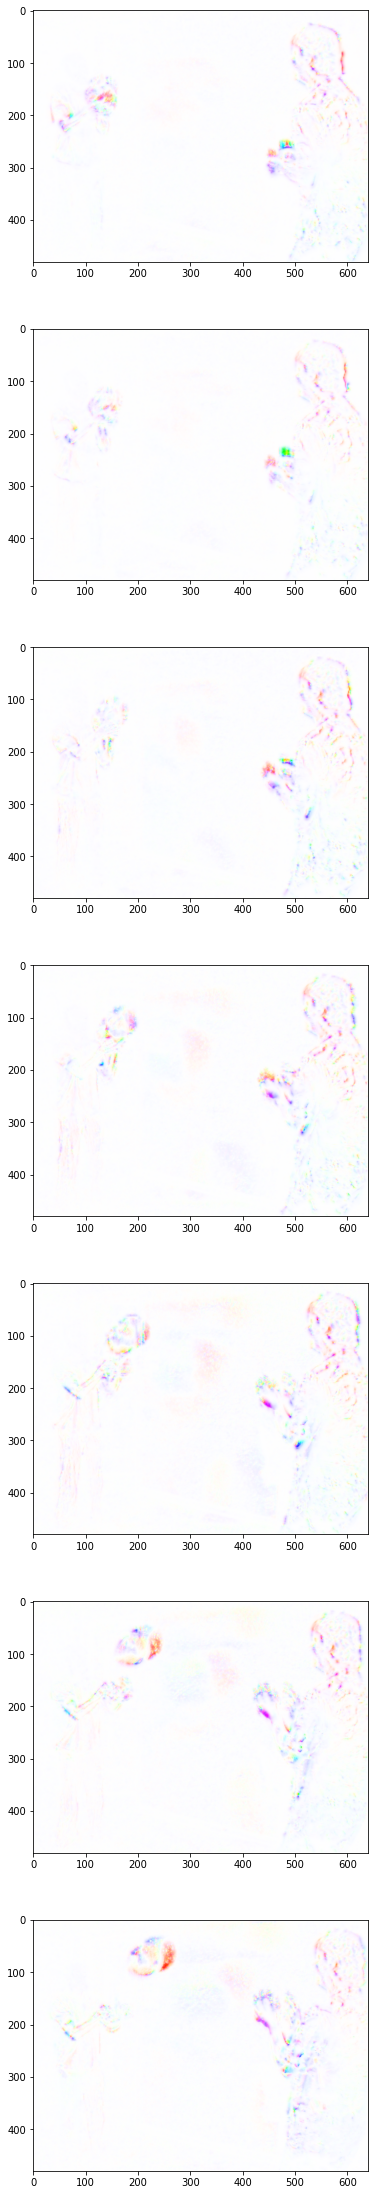

In [6]:
fig, ax = plt.subplots(7, 1, figsize=(6, 40))

x_kernel = np.array([[-1.5, 0, 1.5], [-1.5, 0, 1.5], [-1.5, 0, 1.5]])
y_kernel = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
kernel_average = np.array([[1 / 12, 1 / 6, 1 / 12], [1 / 6, 0, 1 / 6], [1 / 12, 1 / 6, 1 / 12]], float)

for i in range(len(images)-1):
    u, v = horn_schunck(images[i], images[i+1], x_kernel, y_kernel, kernel_average)
    flow_uv = np.stack((u, v), axis=2)
    flow_color = flow_vis.flow_to_color(flow_uv, convert_to_bgr=False)
    ax[i].imshow(flow_color)
    extent = ax[i].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(f'./Outputs/optical-flow{i}.png', bbox_inches=extent)

## Create a Gif

MovieWriter ffmpeg unavailable; using Pillow instead.


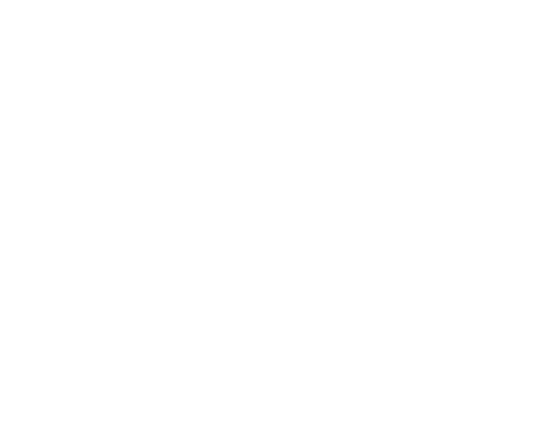

In [7]:
fig, ax = plt.subplots(1, 1, figsize = (8, 6))
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.1, hspace=0)
ax.axis('off')
ims = []

for i in range(6):
    im = ax.imshow(plt.imread(f'./Outputs/optical-flow_HornSchunck{i}.png'), animated = True)
    ims.append([im])

gif = animation.ArtistAnimation(fig, ims, interval=100)
gif.save('./Outputs/flow.gif')